# Decoded Quantum Interferometry for the max-XORSAT Problem

<em style="color:gray;">Copyright (c) 2025 QuAIR team. All Rights Reserved.</em>

This tutorial compares the performance of classical methods and Decoded Quantum Interferometry (DQI) implemented by quairkit for the max-XORSAT problem.

# Max-XORSAT Problem

Finding the best solution(s) from a large, finite set of possible candidates is known as **combinatorial optimization**.  A well-known problem from this field is the **traveling salesman problem**.  Mathematically, this can be phrased as trying to maximize an objective function whose domain is large and discrete.

The **max-XORSAT** problem is a simple example of this, where we are given an $m \times n$ matrix $B$ (with $m > n$) and a vector $\mathbf{v}$ of length $m$, and are required to find the $n$-bit string $\mathbf{x}$ that satisfies the maximum number of constraints imposed by the $m$ linear mod-2 equations,

$
B\mathbf{x} = \mathbf{v}
$

Since this system of equations is over $\mathbb{F}_2$, the matrix and vectors only contain zeros and ones.


The objective function we are aiming to maximize is:

$
f(\mathbf{x}) = \sum_{i=1}^{m} (-1)^{v_i + \mathbf{b}_i \cdot \mathbf{x}} = \sum_{i=1}^{m} f_i(\mathbf{x}),
$

where $\mathbf{b}_i$ is the $i$-th row of matrix $B$.


You can verify that this function represents the **number of satisfied equations minus the number of unsatisfied ones**, by considering that when the equation is satisfied, the exponent $v_i + \mathbf{b}_i \cdot \mathbf{x}$ is always even, and that it is odd in the opposite case.



## Classical Solutions & Their Complexity
| **Type** | **Algorithm** | **Idea** | **Time** | **Guarantee / Notes** |
| --- | --- | --- | --- | --- |
| **Exact** | Brute force | Try all $2^n$assignments; evaluate each in $O(m)$ | $O(2^nm)$ | Exact but exponential |
|  | Rank-based search | Do Gaussian elimination over $\mathbb F_2$ to reduce to rank (r); branch only on (r) “free” variables (or use nullspace basis) | $O(2^{r} \mathrm{poly}(n,m))$ | Exact; often much faster than ($2^n$) when constraints are dependent |
|  | Branch-and-bound + elimination | Repeated elimination to simplify + upper bounds to prune | Exponential (instance-dependent) | Exact in practice on many sparse instances |
|  | 0–1 ILP / Pseudo-Boolean (PB) | Encode parity clauses; modern PB/SAT solvers with cutting/branching | Worst-case exponential | Exact; very strong on medium-size instances |
| **Feasibility (XORSAT) only** | Gaussian elimination | Solve (Bx=v) over $\mathbb F_2$ | $O(mn)$ | **Exact**, but **only** for feasibility; doesn’t optimize violations |
| **Approximation** | Random assignment | Set each bit uniformly at random | $O(1)$ (plus evaluation $O(m)$) | (1/2)-approx in expectation for unweighted; derandomizable |
|  | Method of conditional expectations | Greedily fix bits to keep expected score ≥ baseline | $O(mn)$ | Deterministic (1/2)-approx (works for weights too) |
|  | Max-2-Lin(2) via SDP (GW) | Reduce to signed Max-Cut; solve SDP, round (Goemans–Williamson) | Polytime SDP ~ ( $\tilde O(n^3) $) | **0.878…-approx** for k=2 case |
|  | LP/SDP for k≥3 | Relax to LP/SDP then round | Polytime | No >($1/2+\varepsilon$) approx in general for E3-Lin(2) (hardness); heuristics exist |
|  | Spectral (k=2) | Use top eigenvector of signed Laplacian; threshold | $O(m)–O(n^3)$ | Provable constant-factor (weaker than SDP), very fast |
|  | Belief / Max-Sum Propagation | Message passing on factor graph | $O(m)$ per iter | Exact on trees; strong heuristics on sparse random graphs |
| **Heuristics** | Local search (bit-flip / Kernighan–Lin style) | Maintain clause gains; flip improving bits or blocks | $O(m)$ per sweep (amort.) | Very competitive in practice; no worst-case ratio |
|  | Simulated annealing / Tabu | Escape local minima with randomness / memory | Depends on schedule | Heuristic |

In [35]:
import torch
import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.qinfo import *
import matplotlib.pyplot as plt
qkit.set_dtype('complex128')
from quairkit import *
import numpy as np
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

Let's define the conditions for our specific max-XORSAT problem and visualize the objective function in a histogram when randomly sampling bit strings $\mathbf{x}$ from a uniform distribution. Later, we'll use samples generated by the DQI algorithm and compare their quality, in terms of the objective function, to this initial plot to see how well DQI performs.

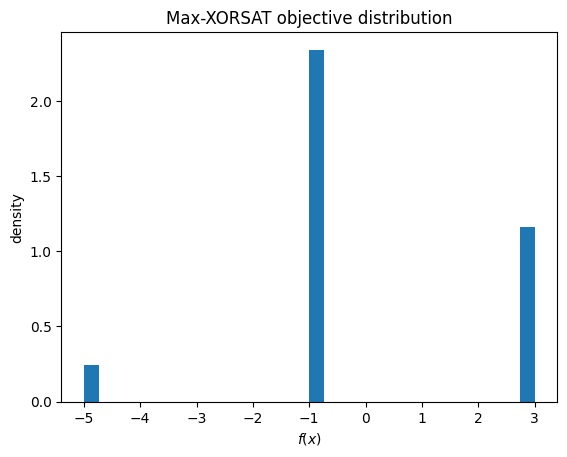

In [36]:
torch.manual_seed(0)

B = torch.tensor([[1, 0, 0, 0], [1, 1, 0, 0], [0, 1, 1, 0], [0, 0, 1, 1], [0, 0, 0, 1]], dtype=torch.int64)

v = torch.tensor([1, 0, 1, 0, 1], dtype=torch.int64)


m, n = B.shape
n_samples = 10000

def objective_function(x: torch.Tensor) -> torch.Tensor:
    Bx = (B @ x) % 2          
    parity = (v + Bx) % 2
    f = (1 - 2 * parity).sum()
    return f.item()

samples = torch.randint(0, 2, size=(n_samples, n), dtype=torch.int64)
f_x_array_random = [objective_function(sample) for sample in samples]

plt.hist(f_x_array_random, bins=30, density=True)
plt.xlabel(r"$f(x)$")
plt.ylabel("density")
plt.title("Max-XORSAT objective distribution")
plt.show()

# The DQI Algorithm
The DQI algorithm for solving the max-XORSAT problem involves three qubit 
registers: a weight, an error, and a syndrome register, with dimensions 
$\lceil \log_2 \ell \rceil$, $m$, and $n$, respectively.

1. **Embed weight coefficients:**  
   Prepare the state  
   $$
   \displaystyle \sum_{k=0}^{\ell} w_k |k\rangle
   $$  
   in the weight register to encode the degree-$\ell$ polynomial.

2. **Prepare Dicke states:**  
   Generate Dicke states on the error register, conditioned on the value $k$ 
   in the weight register:
   $$
   \sum_{k=0}^{\ell} w_k |k\rangle 
   \frac{1}{\sqrt{\binom{m}{k}}}
   \sum_{|\mathbf{y}| = k} |\mathbf{y}\rangle.
   $$

3. **Uncompute and discard the weight register.**

4. **Encode the vector of constraints:**  
   Encode $\mathbf{v}$ by imparting a phase $(-1)^{\mathbf{v}\cdot\mathbf{y}}$:
   $$
   \sum_{k=0}^{\ell}
   w_k \frac{1}{\sqrt{\binom{m}{k}}}
   \sum_{|\mathbf{y}| = k}
   (-1)^{\mathbf{v}\cdot\mathbf{y}}
   |\mathbf{y}\rangle.
   $$

5. **Compute syndrome:**  
   Compute $B^T\mathbf{y}$ into the syndrome register:
   $$
   \sum_{k=0}^{\ell}
   w_k \frac{1}{\sqrt{\binom{m}{k}}}
   \sum_{|\mathbf{y}| = k}
   (-1)^{\mathbf{v}\cdot\mathbf{y}}
   |\mathbf{y}\rangle
   |B^T\mathbf{y}\rangle.
   $$

6. **Decode and uncompute:**  
   Use $B^T\mathbf{y}$ to find $\mathbf{y}$ and uncompute the error register.

7. **Hadamard transform and sample:**  
   Apply the Hadamard transform to obtain $|P(f)\rangle$ and sample to get solutions.


# Quairkit implementation of DQI


# Amplitude Encoding: Weight Coefficients

We are going to prepare the superposition 
$\sum_{k=0}^{\ell} w_k \lvert k\rangle$.

As previously stated, the weight register is made up of 
$\lceil \log_2(\ell + 1) \rceil \le \ell$ qubits, which means that the index $k$ 
is being binary encoded. The coefficients $w_k$ are chosen such that they 
maximize the number of satisfied linear equations. These optimal weights 
are the components of the principal eigenvector of an 
$(\ell+1)\times(\ell+1)$ symmetric tridiagonal matrix:


\begin{pmatrix}
0 & a_1 &        &        &        \\
a_1 & d & a_2    &        &        \\
    & a_2 & 2d   & \ddots &        \\
    &     & \ddots & \ddots & a_\ell \\
    &     &        & a_\ell & \ell d
\end{pmatrix}


with $a_k = \sqrt{k(m-k+1)}$ and 
$d = \dfrac{p - 2r}{\sqrt{r(p-r)}}$.

Here, $p$ is the number of elements of the finite field where 
our problem is defined (in this case, $p = 2$), and $r$ is defined as 
the number of inputs that will yield $f_i = +1$. It is assumed that 
$r = 1$ in this step.

In [37]:
p = 2
r = 1
d = (p - 2 * r) / torch.sqrt(torch.tensor(r * (p - r), dtype=torch.float64))
l = 2

num_weight_qubits = int(torch.ceil(torch.log2(torch.tensor(l+1, dtype=torch.float64))).item())
weight_register = range(num_weight_qubits)
m_register = range(num_weight_qubits, m + num_weight_qubits)
n_register = range(m + num_weight_qubits, n + m + num_weight_qubits)

def w_k_optimal(m: int, l: int, d) -> torch.Tensor:
    dtype = torch.float64
    diag_main_vals = torch.arange(l + 1, dtype=dtype) * d
    A = torch.diag(diag_main_vals)
    
    i = torch.arange(1, l + 1, dtype=dtype) 
    sup_vals = torch.sqrt(i * (m - (i - 1)))  
    A[:-1, 1:] += torch.diag(sup_vals)       
    A[1:, :-1] += torch.diag(sup_vals)        
  
    eigvals, eigvecs = torch.linalg.eigh(A)  
    w = eigvecs[:, -1]                       

    return w

w_k = w_k_optimal(m, l, d)
print("The optimal values for w are", w_k.tolist())


The optimal values for w are [0.4385290096535146, 0.7071067811865476, 0.5547001962252291]


# Prepare Dicke states with k excitations


For this step, we need a conditional operation that prepares Dicke states 
$\lvert D^{m}_{k} \rangle$ — where the superscript is the number of qubits 
and the subscript is the number of excitations — for each index $k$ in the 
weight register. Dicke states are another way of referring to a uniform 
superposition of all bit strings of a determined Hamming weight. For our 
particular example, we will prepare Dicke states with one and two excitations.
Before implementing the conditional operation, let’s briefly review a method for preparing such states as presented in [2].

In [38]:
def ccry(cir, theta, controls, target):
    """Implements CCRY using decomposition without ancilla."""
    c1, c2 = controls 
    cir.ry(target, theta / 4)
    cir.cnot([c2, target])
    cir.ry(target, -theta / 4)
    cir.cnot([c1, target])
    cir.ry(target, theta / 4)
    cir.cnot([c2, target])
    cir.ry(target, -theta / 4)
    cir.cnot([c1, target])

In [39]:
def SCS(m_val, k, cir: Circuit):
    theta_1 = 2 * torch.arccos(
        torch.sqrt(torch.tensor(1.0 / m_val, dtype=torch.float64))
    )

    cir.cx([m_val - 2, m_val - 1])
    cir.cry(qubits_idx=[m_val - 1, m_val - 2], param=theta_1)
    cir.cx([m_val - 2, m_val - 1])

    for ell in range(2, k + 1):
        theta_ell = 2 * torch.arccos(
            torch.sqrt(torch.tensor(ell / m_val, dtype=torch.float64))
        )

        cir.cx([m_val - ell - 1, m_val - 1])

        ccry(
            cir,
            theta_ell,
            controls=[m_val - 1, m_val - ell],
            target=m_val - ell - 1,
        )

        cir.cx([m_val - ell - 1, m_val - 1])


In [40]:
def prepare_dicke_cir(m, k):
    """Prepares a Dicke state with m qubits and k excitations."""
    cir = Circuit(m)

    for wire_idx in range(m - k, m):
        cir.x(wire_idx)

    for i in reversed(range(k + 1, m + 1)):
        SCS(i, k, cir)
    for i in reversed(range(2, k + 1)):
        SCS(i, i - 1, cir)

    return cir


In [41]:
def embed_weights(cir, w_k, weight_register):
    """Prepare 2-qubit weight register in the state:
       w0|00> + w1|01> + w2|10> + 0|11>.
       
       weight_register: [q0, q1]
    """
    vec = torch.tensor(w_k, dtype=torch.float64)
    w0, w1, w2 = vec

    # --- Step 1: Apply an RY on the first qubit such that:
    # |ψ1> = sqrt(w0^2 + w1^2) |0> + w2 |1>
    #
    # That is: sin(α/2) = w2, cos(α/2) = sqrt(w0^2 + w1^2)
    s01 = torch.sqrt(w0**2 + w1**2)
    
    alpha = 2 * torch.arcsin(w2)

    q0, q1 = weight_register[0], weight_register[1]
    cir.ry(q0, alpha)

    # The full state is now:
    # sqrt(w0^2 + w1^2) |0>_q0 |0>_q1  +  w2 |1>_q0 |0>_q1

    # --- Step 2: In the subspace where q0 = 0, apply an RY to q1 such that:
    # |0>_q0 |0>_q1  ->  (w0/s01)|00> + (w1/s01)|01>
    #
    # i.e., apply a controlled-RY(β) satisfying:
    # cos(β/2) = w0/s01,  sin(β/2) = w1/s01
    if s01 > 1e-12:
        w0p = w0 / s01
        w1p = w1 / s01
        beta = 2 * torch.arctan2(w1p, w0p)

        # Implement controlled RY on q1, conditioned on q0 = |0>
        cir.x(q0)
        cir.cry(qubits_idx=[q0, q1], param=beta)
        cir.x(q0)

    # Final state (theoretically):
    # w0 |00> + w1 |01> + w2 |10> + 0 |11>


In [42]:
def weight_error_prep(m, w_k):
    total_systems = num_weight_qubits + m + n
    cir = Circuit(total_systems)

    weight_register = [0, 1]
    embed_weights(cir, w_k, weight_register)

    error_idx = list(range(2, 2 + m))

    dicke1 = prepare_dicke_cir(m, k=1)
    U1 = dicke1.unitary_matrix()

    cir.x(weight_register[0])
    cir.control_oracle(
        oracle=U1,
        system_idx=[weight_register] + error_idx
    )
    cir.x(weight_register[0])

    dicke2 = prepare_dicke_cir(m, k=2)
    U2 = dicke2.unitary_matrix()

    cir.x(weight_register[1])
    cir.control_oracle(
        oracle=U2,
        system_idx=[weight_register] + error_idx
    )
    cir.x(weight_register[1])

    return cir


In [43]:
state = zero_state(m+n+num_weight_qubits)
cir1 = weight_error_prep(m, w_k)
state = cir1(state)

In [44]:
def mcx_matrix(num_controls):
    """Builds the unitary matrix for MCX with num_controls controls and 1 target."""
    size = 2 ** (num_controls + 1)
    mat = np.eye(size, dtype=complex)
    mat[-1, -1] = 0
    mat[-1, -2] = 1
    mat[-2, -1] = 1
    mat[-2, -2] = 0
    return torch.tensor(mat, dtype=torch.complex64)

# Uncompute the weight register

After preparing the Dicke states, we uncompute and discard the state of the weight register. In general, this is a straightforward process, as the Hamming weights encoded are known. We accomplished this by generating bit strings of length $m$ with Hamming weight of $2$ using the generate\_bit\_strings function. We then applied a controlled bit flip to the weight register for these specific cases. We did not need to perform any action for bit strings with a Hamming weight of $1$, as the qubit state was already $\lvert 0 \rangle$. From now on, we can choose to disregard the weight register.


In [45]:
def phase_Z(cir, v, error_start=1):
    """Imparts a phase (-1)^{v.y}."""
    for i in range(len(v)):
        if v[i] == 1:
            cir.z(error_start + i)

def generate_bit_strings(length: int, hamming_weight: int):
    """Generates all bit strings of a given length and Hamming weight."""
    results = []
    for positions in combinations(range(length), hamming_weight):
        bit_string = [0] * length
        for p in positions:
            bit_string[p] = 1
        results.append(bit_string)
    return results
            
def uncompute_weight_to_zero(cir, m, m_register, weight_register):
    num_controls = len(m_register)
    mcx_mat = mcx_matrix(num_controls)

    for pattern in generate_bit_strings(m, 1):   # Hamming weight 1
        flips = [m_register[j] for j,b in enumerate(pattern) if b == 0]

        for q in flips: cir.x(q)

        cir.oracle(
            mcx_mat,
            system_idx = m_register + [weight_register[1]]
        )

        for q in flips: cir.x(q)

    for pattern in generate_bit_strings(m, 2):   # Hamming weight 2
        flips = [m_register[j] for j,b in enumerate(pattern) if b == 0]

        for q in flips: cir.x(q)

        cir.oracle(
            mcx_mat,
            system_idx = m_register + [weight_register[0]]
        )

        for q in flips: cir.x(q)


# Encode constraints vector

To impart a phase $(-1)^{\mathbf{v} \cdot \mathbf{y}}$, we perform a Pauli-$Z$ on each qubit for which $v_i = 1$. This is simply a conditional operation within a for loop in the phase\_Z function. Let’s now implement this step, together with the weight uncomputation, in a function encode\_v, and output the resulting quantum state.


In [46]:
def encode_v(m):
    cir = Circuit(2 + m +n)
    weight_register = [0,1]
    m_register = list(range(2, 2+m))

    uncompute_weight_to_zero(cir, m, m_register, weight_register)
    phase_Z(cir, v, error_start=2)

    return cir

cir2 = encode_v(m)
state = cir2(state)
print(state)


-----------------------------------------------------
 Backend: default-pure
 System dimension: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 System sequence: [6, 4, 2, 3, 5, 0, 1, 7, 8, 9, 10]
[0.44+0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
-----------------------------------------------------



# Encode matrix B in the syndrome register

We are almost finished, hang in there! Now, we need to compute $B^{T}\mathbf{y}$ in the syndrome register. While it may not be immediately obvious how to implement this as a unitary operation, the binary nature of the matrix and vector allows for a smooth translation. This operation can be realized using CNOT gates, with controls on the error register and targets on the syndrome register[1]. Specifically, a CNOT is applied for every entry $B^{T}_{ij} = 1$, controlled on the $j$-th qubit of the error register and with the $i$-th qubit of the syndrome register as the target. Let’s implement this in the quantum function ndrome\_prep.


In [47]:
def B_T_multiplication(cir, B_T, error_start, syndrome_start):
    m_local = B_T.shape[1]
    n_local = B_T.shape[0]
    for row_idx in range(n_local):
        for col_idx in range(m_local):
            if B_T[row_idx, col_idx].item() == 1:
                cir.cnot([error_start + col_idx, syndrome_start + row_idx])

def syndrome_prep_circuit():
    cir = Circuit(n+m+2)
    B_T = B.T
    B_T_multiplication(cir, B_T, error_start=m_register[0], syndrome_start=n_register[0])
    return cir

cir3 = syndrome_prep_circuit()
state = cir3(state)


# Decoding


This step is the main challenge of the algorithm: uncomputing the error register $\mathbf{y}$ using the information from the syndrome register $\mathbf{s} = B^{T}\mathbf{y}$ in an efficient way. This would be an easy task if $B$ were always a square matrix; however, since it is not, we need to solve an underdetermined linear system of equations $\mathbf{s} = B^{T}\mathbf{y}$ subject to the constraint $\lvert \mathbf{y} \rvert \le \ell$ given by the known Hamming weights of $\mathbf{y}$. The problem we have just described is precisely the syndrome decoding problem, where $B^{T}$ is the parity-check matrix, $\mathbf{s}$ is the syndrome, and $\mathbf{y}$ is the error.

The kernel of $B^{T}$ defines an error-correcting code. The distance $d$ of this code determines the number of errors it can correct, given by $\lfloor (d-1)/2 \rfloor$. This condition ensures that the decoding problem has a unique solution. For this demo, we choose $\ell = 2$ such that it is less than half the distance of the code $d = 5$ and this condition is met. For a detailed discussion of the restrictions on $\ell$, please refer to the original paper[1].

To keep things simple, we will use a straightforward approach for decoding by building a Lookup Table (LUT) where we compute the syndrome for each possible error using the classical function syndrome\_LUT. While this function might look daunting, it is simply calculating a product between a matrix and a vector, and storing the results in a usable format. (Feel free to explore other decoders such as belief propagation.)

Then, for each syndrome in the syndrome register, the corresponding error is uncomputed in the error register using controlled bit-flip operations. We will now integrate this into our decoding quantum function and see how the syndrome register is uncomputed.

In [48]:
def syndrome_LUT(parity_check_matrix_T):
    """Generates the Lookup table given a parity-check matrix."""
    num_data_qubits = parity_check_matrix_T.shape[1]
    syndrome_dict = {}

    for i in range(2**num_data_qubits):
        error_bitstring = format(i, f"0{num_data_qubits}b")
        error_vector = torch.tensor([int(bit) for bit in error_bitstring])

        syndrome_vector = torch.matmul(parity_check_matrix_T.float(), error_vector.float()) % 2
        syndrome_bitstring = "".join(map(str, syndrome_vector.int().tolist()))

        if syndrome_bitstring not in syndrome_dict:
            syndrome_dict[syndrome_bitstring] = error_bitstring
        else:
            existing_error = syndrome_dict[syndrome_bitstring]
            existing_weight = sum(int(bit) for bit in existing_error)
            current_weight = sum(error_vector.tolist())
            if current_weight < existing_weight:
                syndrome_dict[syndrome_bitstring] = error_bitstring

    # Convert to list-of-lists
    lookup_matrix = []
    for syndrome_str, error_str in syndrome_dict.items():
        syndrome_list = [int(bit) for bit in syndrome_str]
        error_list = [int(bit) for bit in error_str]
        lookup_matrix.append([syndrome_list, error_list])

    # Sort by syndrome
    lookup_matrix.sort(key=lambda x: int("".join(map(str, x[0])), 2))

    return lookup_matrix

# Generate the lookup table
decoding_table = syndrome_LUT(B.T)

def decoding(m, n, previous_state):
    """Quantum circuit decoding and uncomputing error register"""
    total_systems = m + n + num_weight_qubits # error + syndrome + 2 for weight qubit
    cir = Circuit(total_systems)

    # Uncompute syndrome register using a Lookup table
    error_idx    = list(range(2, 2 + m))          # [2 .. 2+m-1]
    syndrome_idx = list(range(2 + m, 2 + m + n))  # [2+m .. 2+m+n-1]

    for syndrome, error in decoding_table:
        for i in range(len(error)):
            if error[i] == 1:
                # Flips for control_values (as before)
                flips = [syndrome_idx[j] for j in range(n) if syndrome[j] == 0]
                
                # Pre-flip: Apply X to simulate negative controls
                for wire in flips:
                    cir.x(wire)  # QuAIRKit supports cir.x(wire)
                
                # Build and apply MCX via oracle
                num_controls = len(syndrome_idx)
                mcx_mat = mcx_matrix(num_controls)  # Use the helper function above
                qubits_idx = syndrome_idx + [error_idx[i]]  # Controls + target
                cir.oracle(mcx_mat, system_idx=qubits_idx)
                
                # Post-flip: Restore
                for wire in flips:
                    cir.x(wire)

    # Execute on previous_state
    state = cir(previous_state)

    return state

# Usage (assuming raw_state_vector from syndrome_prep is previous_state)
state = decoding(m, n, state)
print(state)



-----------------------------------------------------
 Backend: default-pure
 System dimension: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 System sequence: [7, 8, 9, 10, 5, 3, 4, 2, 6, 0, 1]
[0.44+0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
-----------------------------------------------------



# Hadamard transform and sample


After the previous step, we obtained the Hadamard transform of the state we are looking for. The final step is to apply the Hadamard transform to this state to obtain 
$|P(f)\rangle = \sum_{\mathbf{x}} P(f(\mathbf{x})) \, |\mathbf{x}\rangle.$ 
Let us write a DQI quantum function containing all the steps of the algorithm previously described.


In [49]:
def Hadamard(previous_state):

    total_systems = 2 + m + n
    cir = Circuit(total_systems)

    for q in range(2 + m, 2 + m + n):
        cir.h(q)

    state = cir(previous_state)

    traced_state = partial_trace(state=state,
                                 trace_idx=list(range(0, 2 + m)),
                                 system_dim=[2] * total_systems)
    return traced_state




We will collect samples, calculate their objective values, and build a histogram to compare with the random sampling done at the beginning of the demo.


x = 0000 → p(x) = 0.028846
x = 0001 → p(x) = 0.028846
x = 0010 → p(x) = 0.028846
x = 0011 → p(x) = 0.028846
x = 0100 → p(x) = 0.006015
x = 0101 → p(x) = 0.006015
x = 0110 → p(x) = 0.006015
x = 0111 → p(x) = 0.006015
x = 1000 → p(x) = 0.028846
x = 1001 → p(x) = 0.028846
x = 1010 → p(x) = 0.028846
x = 1011 → p(x) = 0.028846
x = 1100 → p(x) = 0.186293
x = 1101 → p(x) = 0.186293
x = 1110 → p(x) = 0.186293
x = 1111 → p(x) = 0.186293


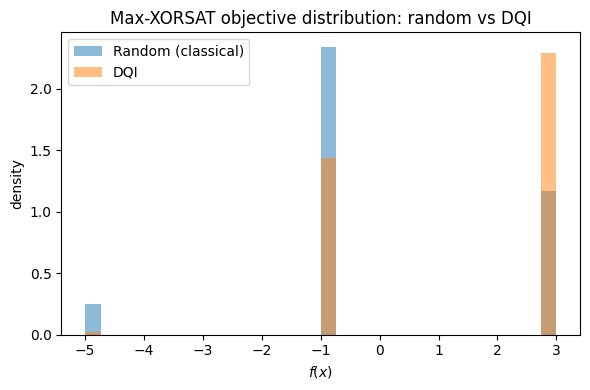

In [50]:
state = Hadamard(state)
prob = state.measure()  

for i, p in enumerate(prob):
    bitstring = format(i, f"0{n}b")      
    print(f"x = {bitstring} → p(x) = {p.item():.6f}")

samples_dict = prob_sample(prob, n_samples)   

f_x_array_dqi = []

for bitstring, counts in samples_dict.items():
    num = int(counts.item())         
    x_bits = torch.tensor([int(b) for b in bitstring], dtype=torch.int64)
    fx = objective_function(x_bits)  
    f_x_array_dqi.extend([fx] * num)  

plt.figure(figsize=(6, 4))
plt.hist(f_x_array_random, bins=30, density=True, alpha=0.5, label="Random (classical)")
plt.hist(f_x_array_dqi,     bins=30, density=True, alpha=0.5, label="DQI")

plt.xlabel(r"$f(x)$")
plt.ylabel("density")
plt.title("Max-XORSAT objective distribution: random vs DQI")
plt.legend()
plt.tight_layout()
plt.show()

## References

[1] Jordan, Stephen P., et al. "Optimization by decoded quantum interferometry." Nature 646.8086 (2025): 831-836.

[2] Bärtschi, Andreas, and Stephan Eidenbenz. "Deterministic preparation of Dicke states." International Symposium on Fundamentals of Computation Theory. Cham: Springer International Publishing, 2019.

In [51]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.1
torch: 2.8.0+cu128
torch cuda: 12.8
numpy: 1.26.4
scipy: 1.15.3
matplotlib: 3.10.5
---------SYSTEM---------
Python version: 3.10.18
OS: Linux
OS version: #88-Ubuntu SMP PREEMPT_DYNAMIC Sat Oct 11 09:28:41 UTC 2025
---------DEVICE---------
CPU:  AMD EPYC 9554 64-Core Processor
GPU: (0) NVIDIA GeForce RTX 3090
     (0) NVIDIA GeForce RTX 3090
